# CIV1498 - Introduction to Data Science
## Project - Toronto Bike Share
## PART II: Eploratory Data Analysis
### By: Gneiss Data (Greig Knox and Yoko Yanagimura)

In this section, we will work with the cleaned and merged bike station and weather data derived from Part I. We will explore the dataset to extract insights that will help answer some of the questions posed by the City of Toronto. 

The list below shows the questions that were posed by the City of Toronto. We aim to answer the following questions through the analyses presented in this notebook:

1. Is there an increasing trend of usage from 2017 to 2020 and is the trend the same for both Casual and Annual Member riders?

2. Is there a difference in usage behaviour between Casual and Annual Member riders?

3. Which neighbourhoods have seen the largest number of rides depart from bike stations located within their boundaries?

4. Which neighbourhoods have seen the largest number of rides end at bike stations located within their boundaries?

5. How popular is FREE RIDE WEDNESDAYS?

6. How does the weather change the way people use the bike share system?

7. What weather features are most influential (temperature, humidity, precipitation, etc.)?

8. When are people using the bike share system? How does usage vary across the year, the week, and the day?

9. How did usage change in 2020 due to the pandemic and government-mandated lockdowns?

10. How do statutory holidays impact demand?

We have also conducted a series of analyses to provide some of our own insights into the dataset. We have attempted to answer the following questions through our analyses:

1. Does bike-share usage vary depending on proximity to TTC subway and streetcar stations?

2. Are there seasonal or geographic trends in trip duration?

3. If everyone is travelling along bike paths, which bike paths are the most congested and at what times of the day?

4. Are people using the bike-share system to access TTC stations?

5. How are people using the system, is it to commute to work or to explore the city?

## 0. Setup Notebook and Import Data

In [7]:
# Import 3rd party libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pytz
import fuzzywuzzy
from fuzzywuzzy import process
import chardet
import string
import datetime

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Centre all the charts displayed in this notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
display: table-cell;
text-align: center;
vertical-align: middle;
}
</style>
""")

We will import the cleaned bike trip dataset that will be used for analysis. 

In [2]:
#Import cleaned bike trip data
df_trips_data=pd.read_csv('df_merged_data.csv')
df_trips_data.set_index(keys='trip_id', drop=True, inplace=True)
df_trips_data.head()

,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,...,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
trip_id,,,,,,,,,,,,,,,,,,,,,
712441,NaN,274,7006.0,2017-01-01 00:03:00-05:00,Bay St / College St (East Side),7021.0,2017-01-01 00:08:00-05:00,Bay St / Albert St,NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712442,NaN,538,7046.0,2017-01-01 00:03:00-05:00,Niagara St / Richmond St W,7147.0,2017-01-01 00:12:00-05:00,King St W / Fraser Ave,NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712443,NaN,992,7048.0,2017-01-01 00:05:00-05:00,Front St / Yonge St (Hockey Hall of Fame),7089.0,2017-01-01 00:22:00-05:00,Church St / Wood St,NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712444,NaN,1005,7177.0,2017-01-01 00:09:00-05:00,East Liberty St / Pirandello St,7202.0,2017-01-01 00:26:00-05:00,Queen St W / York St (City Hall),NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day
712445,NaN,645,7203.0,2017-01-01 00:14:00-05:00,Bathurst St / Queens Quay W,7010.0,2017-01-01 00:25:00-05:00,King St W / Spadina Ave,NaN,Member,...,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,clear_day


# 1. Understanding the Dataset

Before diving into the analysis, it is important to understand and define the following properties about our dataset. 
1. Structure - what is the format of our data file?

2.  Granularity - how fine or coarse is each row and column?

3. Scope - how complete is our data set?

Some of these questions were already explored in the Part I (Data Cleaning and Wrangling), but we would like to reiterate the subject in more details in this section. 

### Structure

The structure of the datafile can be examined by looking at the "shape". We can see that there are 7924851 rows and 32 columns. 

In [10]:
df_trips_data.shape

(8008200, 31)

What are the fields (e.g. columns) in each record? What is the type of each column? We can use .columns to examine this. We can see that there data about the trip and the associated information about the weather when the trip was taken. We joined the bike trip data and the weather dataframe together in Part I. 

In [4]:
df_trips_data.columns

Index(['subscription_id', 'trip_duration', 'start_station_id', 'start_time',
       'start_station_name', 'end_station_id', 'end_time', 'end_station_name',
       'bike_id', 'user_type', 'start_station_name_npl',
       'end_station_name_npl', 'start_station_lat', 'start_station_lon',
       'end_station_lat', 'end_station_lon', 'merge_time', 'year', 'month',
       'day', 'time', 'temp_c', 'dew_point_temp_c', 'rel_hum_',
       'wind_dir_10s_deg', 'wind_spd_kmh', 'visibility_km', 'stn_press_kpa',
       'hmdx', 'wind_chill', 'weather'],
      dtype='object')

To summarize the data cleaning conducted in Part I, the records removed from the dataset include:

- Trip records outside the January 1, 2017 and October 31, 2020 range 
- Trip records with extreme and unrealistic trip durations based on the inter-quartile range
- Trip records with unknown start or end locations (i.e. missing station name and station id)
- Trip records with start or end stations not included in the provided bike station dataset (i.e. unknown start and end coordinates)



In [5]:
#Percentage of Data Containing Null Record
trips_data_missing = pd.DataFrame(df_trips_data.isnull().sum())
trips_data_missing = trips_data_missing.rename(columns={0:"count"})
trips_data_missing['percent_nulldata']=round(trips_data_missing['count']/df_trips_data.shape[0] * 100,1)

trips_data_missing

,count,percent_nulldata
subscription_id,3199754,40.0
trip_duration,0,0.0
start_station_id,0,0.0
start_time,0,0.0
start_station_name,156,0.0
end_station_id,0,0.0
end_time,0,0.0
end_station_name,910,0.0
bike_id,3199754,40.0
user_type,0,0.0


# 1. Is there an increasing trend of usage from 2017 to 2020 and is the trend the same for both Casual and Annual Member riders?
-> Firtly Group by week do determine the number of riders per week, this data can be used to determine the trend in the total number of riders. The same data frame can also be used to differentate between Causal and Annual Members

In [12]:

df_trips_data['start_time']=pd.to_datetime(df_trips_data['start_time'])
df_trips_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8008200 entries, 712441 to 10293875
Data columns (total 31 columns):
 #   Column                  Dtype                                 
---  ------                  -----                                 
 0   subscription_id         float64                               
 1   trip_duration           int64                                 
 2   start_station_id        float64                               
 3   start_time              datetime64[ns, pytz.FixedOffset(-300)]
 4   start_station_name      object                                
 5   end_station_id          float64                               
 6   end_time                object                                
 7   end_station_name        object                                
 8   bike_id                 float64                               
 9   user_type               object                                
 10  start_station_name_npl  object                              

In [19]:
df_trips_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8008200 entries, 712441 to 10293875
Data columns (total 31 columns):
 #   Column                  Dtype                                 
---  ------                  -----                                 
 0   subscription_id         float64                               
 1   trip_duration           int64                                 
 2   start_station_id        float64                               
 3   start_time              datetime64[ns, pytz.FixedOffset(-300)]
 4   start_station_name      object                                
 5   end_station_id          float64                               
 6   end_time                object                                
 7   end_station_name        object                                
 8   bike_id                 float64                               
 9   user_type               object                                
 10  start_station_name_npl  object                              

In [28]:
df_trips_data['time_round_days'] = df_trips_data['start_time'].dt.round('d')

In [31]:
df_usage_perd = pd.DataFrame(df_trips_data.groupby('time_round_days').agg('count')
df_usage_perd

,subscription_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,...,temp_c,dew_point_temp_c,rel_hum_,wind_dir_10s_deg,wind_spd_kmh,visibility_km,stn_press_kpa,hmdx,wind_chill,weather
time_round_days,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00-05:00,0,110,110,110,110,110,110,110,0,110,...,110,110,110,110,110,110,110,0,15,110
2017-01-02 00:00:00-05:00,0,529,529,529,529,529,529,529,0,529,...,529,529,529,529,529,529,529,0,11,529
2017-01-03 00:00:00-05:00,0,1015,1015,1015,1015,1015,1015,1015,0,1015,...,1015,1015,1015,1015,1015,1015,1015,0,0,1015
2017-01-04 00:00:00-05:00,0,1040,1040,1040,1040,1040,1040,1040,0,1040,...,1040,1040,1040,1040,1040,1040,1040,0,18,1040
2017-01-05 00:00:00-05:00,0,1299,1299,1299,1299,1299,1299,1299,0,1299,...,1299,1299,1299,1299,1299,1299,1299,0,1299,1299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-28 00:00:00-05:00,4949,4949,4949,4949,4945,4949,4949,4946,4949,4949,...,4949,4949,4949,4949,4949,4949,4949,0,0,4949
2020-10-29 00:00:00-05:00,8450,8450,8450,8450,8436,8450,8450,8440,8450,8450,...,8450,8450,8450,8450,8450,8450,8450,0,0,8450
2020-10-30 00:00:00-05:00,6480,6480,6480,6480,6470,6480,6480,6470,6480,6480,...,6480,6480,6480,6480,6480,6480,6480,0,0,6480


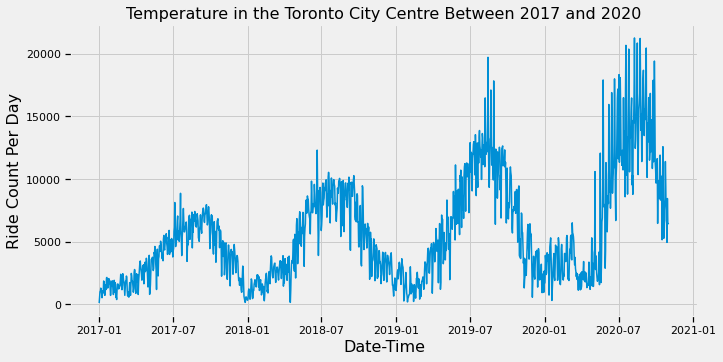

In [32]:
plt.figure(figsize=(10,5))
usage=sns.lineplot(x=df_usage_perd.index,y=df_usage_perd['start_station_id'])
usage.axes.set_title("Temperature in the Toronto City Centre Between 2017 and 2020",
                      fontsize=16)
usage.set_ylabel("Ride Count Per Day",
                  fontsize=16)
usage.set_xlabel("Date-Time",
                  fontsize=16)
plt.show()

#think we need to change this to a bar graph